# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Business Understanding

To summarize the introduction we are interested in finding the groups that are most responsive to which types of offers and to maximize the promotion strategy using uplift modeling. and for each startgey we will have a different promotional model. 
To segmenet the customers groups i will create Recency-Frequency-Monetary RFM clustering(An RFM analysis evaluates which customers are of highest and lowest value to an organization based on purchase recency, frequency, and monetary value, in order to reasonably predict which customers are more likely to make purchases again in the future)
This work will be divided into the following section:

    1) Data Understanding

    2) Preprocessing 

    3) EDA

    4) Feature Engineering

    5) Modeling

# Data Understanding
In this section i look into the 3 given datasets to identify initial preprocessing on the data. 

In [3]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Portfolio data set 
Lets start with exploring the offers dataset:

In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
portfolio[portfolio.offer_type =='bogo']

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5


In [6]:
portfolio[portfolio.offer_type =='discount']

,channels,difficulty,duration,id,offer_type,reward
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [7]:
portfolio[portfolio.offer_type =='informational']

,channels,difficulty,duration,id,offer_type,reward
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


**We have 3 main offer types: BOGO, informational, discount. These types can be further subdivided based on the duration, difficulty and the channels into 10 types of offers as follows:**

    1) B3_10_7_10 as part BOGO: sent to 3 channels (email, mobile, social), difficulty 10, duration 7 days and a reward of 10.

    2) B4_10_5_10

    3) B3_5_7_5

    4) B4_5_5_5

    5) D2_20_10_5

    6) D4_7_7_3

    7) D4_10_10_2

    8) D3_10_7_2

    9) I3_0_4_0

    10) I3_0_3_0

The first letter is used for the offer type, followed by the diffculty, duration and the last value is for the reward and these values are seperated by _.

In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [10]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


**From the above we can identify the following cleaning:**

1) channels contain a list of values so in order to handle this 

2) rename id into offer_id

3) change the offer type to have a symbol for each offer type to make it easier to create different models

4) handel the categorical offer_type 
### Profile

In [11]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 796.9+ KB


In [13]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [11]:
# check for any duplicated id values
profile[profile.id.duplicated()]

,age,became_member_on,gender,id,income


Lets investigate the missing values in the income and age  

In [14]:
# get missing values in each column dataframe 
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [21]:
profile[((profile.gender.isnull()) & (profile.income.isnull()))]

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [20]:
# first i want to check the columns that have even na gender and income
profile[((profile.gender.isnull()) & (profile.income.isnull()))].age.unique()

array([118])

so from the above we can see that age column has a value of 118 when the income and gender are null. 

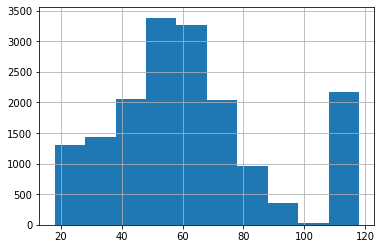

In [15]:
profile.age.hist()

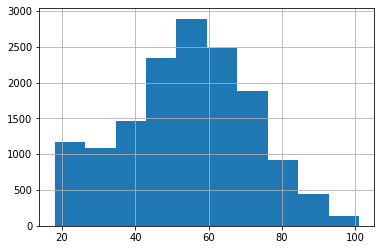

In [22]:
profile[profile.age !=118].age.hist()

In [23]:
profile[profile.age !=118].age.describe()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64

In [33]:
profile[(profile.age < 118) & (profile.age > 66)]

,age,became_member_on,gender,id,income
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
22,78,20170616,F,c27e0d6ab72c455a8bb66d980963de60,71000.0
30,67,20140823,M,5917d13f6fa04286abdf95f4d5cefb1e,96000.0
33,96,20171117,F,868317b9be554cb18e50bc68484749a2,89000.0
35,69,20160814,F,102e9454054946fda62242d2e176fdce,57000.0
40,75,20151112,M,6e014185620b49bd98749f728747572f,40000.0
46,69,20130918,F,8e7c7465e98c43d8a01f51e2b5c29542,37000.0
50,79,20150415,F,a3b9b4bf115e4564933ea2e4bc936843,48000.0
58,78,20161009,F,fe8264108d5b4f198453bbb1fa7ca6c9,93000.0


so from the above we notice that even when we remove age values of 118, we still have a maximum value of 101 for the age so to check if this should be considered an outlier i will use the z-score method.  
In this outlier detection method we calculate the z-score values and then we set a thershould for outlier values.

In [48]:
#TODO: move this method to a utility function and then import here
def outliers_z_score(col, thershold = 2):
    """
    detect outliers s
    """
    col_mean = col.mean()
    col_stdev = col.std()
    z_scores = (col - col_mean) / col_stdev
    
    return np.where(np.abs(z_scores) > thershold)
    
outliers_z_score(profile.age)

(array([    0,     2,     4, ..., 16989, 16991, 16994]),)

In [46]:
profile.iloc[outliers_z_score(profile.age)].age.unique()

array([118])

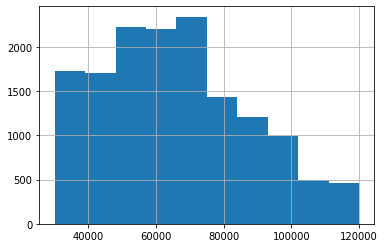

In [16]:
profile.income.hist()

**From the above we can identify the following cleaning:**

1) handle outliers in the age columns and the missing values in gender and income columns

2) label encode the gender attribute to 0 or 1.

3) change the became_member_on to date type instead of the current int value

4) rename id to person_id

### Transcript dataset 

In [22]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [19]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [20]:
transcript.tail(10)

,event,person,time,value
306524,transaction,d613ca9c59dd42f497bdbf6178da54a7,714,{'amount': 25.14}
306525,transaction,eec70ab28af74a22a4aeb889c0317944,714,{'amount': 43.58}
306526,transaction,24f56b5e1849462093931b164eb803b5,714,{'amount': 22.64}
306527,offer completed,24f56b5e1849462093931b164eb803b5,714,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306528,transaction,5ca2620962114246ab218fc648eb3934,714,{'amount': 2.2}
306529,transaction,b3a1272bc9904337b331bf348c3e8c17,714,{'amount': 1.5899999999999999}
306530,transaction,68213b08d99a4ae1b0dcb72aebd9aa35,714,{'amount': 9.53}
306531,transaction,a00058cf10334a308c68e7631c529907,714,{'amount': 3.61}
306532,transaction,76ddbd6576844afe811f1a3c0fbb5bec,714,{'amount': 3.5300000000000002}
306533,transaction,c02b10e8752c4d8e9b73f918558531f7,714,{'amount': 4.05}


In [52]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 11.7+ MB


**From the above we can identify the following cleaning:**

1) handle value column to extract either the transaction value or the offer_id. 

2) rename person to person_id

3) change the time to days instead of hours.

4) handle the categorical values for the event column 


## Preprocessing

In [34]:
# Un wrap the dictionary into 2 columns for offer id and amount 
transcript['value'].apply(lambda x: x.get('offer id', np.nan))

0         9b98b8c7a33c4b65b9aebfe6a799e6d9
1         0b1e1539f2cc45b7b9fa7c272da2e1d7
2         2906b810c7d4411798c6938adc9daaa5
3         fafdcd668e3743c1bb461111dcafc2a4
4         4d5c57ea9a6940dd891ad53e9dbe8da0
5         f19421c1d4aa40978ebb69ca19b0e20d
6         2298d6c36e964ae4a3e7e9706d1fb8c2
7         3f207df678b143eea3cee63160fa8bed
8         0b1e1539f2cc45b7b9fa7c272da2e1d7
9         0b1e1539f2cc45b7b9fa7c272da2e1d7
10        0b1e1539f2cc45b7b9fa7c272da2e1d7
11        0b1e1539f2cc45b7b9fa7c272da2e1d7
12        ae264e3637204a6fb9bb56bc8210ddfd
13        3f207df678b143eea3cee63160fa8bed
14        0b1e1539f2cc45b7b9fa7c272da2e1d7
15        fafdcd668e3743c1bb461111dcafc2a4
16        0b1e1539f2cc45b7b9fa7c272da2e1d7
17        2906b810c7d4411798c6938adc9daaa5
18        9b98b8c7a33c4b65b9aebfe6a799e6d9
19        ae264e3637204a6fb9bb56bc8210ddfd
20        2906b810c7d4411798c6938adc9daaa5
21        9b98b8c7a33c4b65b9aebfe6a799e6d9
22        4d5c57ea9a6940dd891ad53e9dbe8da0
23        2

In [35]:
transcript['value'].apply(lambda x: x.get('amount', np.nan))

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12          NaN
13          NaN
14          NaN
15          NaN
16          NaN
17          NaN
18          NaN
19          NaN
20          NaN
21          NaN
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
          ...  
306504     4.89
306505     4.48
306506      NaN
306507      NaN
306508     1.19
306509      NaN
306510    14.31
306511     2.37
306512     6.92
306513    12.73
306514     8.20
306515     2.60
306516     9.20
306517    11.70
306518    40.67
306519    31.13
306520     1.64
306521    17.35
306522     4.42
306523    18.35
306524    25.14
306525    43.58
306526    22.64
306527      NaN
306528     2.20
306529     1.59
306530     9.53
306531     3.61
306532     3.53
306533     4.05
Name: value, Length: 306

In [37]:
transactions_df = transcript[transcript.event == 'transaction']
transactions_df.head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [47]:
# get the amount from the value

transactions_df['amount'] = transactions_df['value'].apply(lambda x: x.get('amount', np.nan))
transactions_df.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,event,person,time,value,amount
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},18.97


In [48]:
tx_user = pd.DataFrame(profile['id'].unique())
tx_user.columns = ['CustomerID']

#get the last transaction 
max_purchase = transactions_df.groupby('person').time.max().reset_index()
max_purchase.columns = ['CustomerID','MaxPurchaseDate']

#we take our observation point as the max invoice date in our dataset
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate'])

tx_user = pd.merge(tx_user, max_purchase[['CustomerID','Recency']], on='CustomerID')

tx_user.head()

,CustomerID,Recency
0,68be06ca386d4c31939f3a4f0e3dd783,18
1,0610b486422d4921ae7d2bf64640c50b,186
2,38fe809add3b4fcf9315a9694bb96ff5,18
3,78afa995795e4d85b5d9ceeca43f5fef,180
4,a03223e636434f42ac4c3df47e8bac43,102


In [49]:
tx_user.Recency.describe()

count    16578.000000
mean        85.425262
std         82.766010
min          0.000000
25%         24.000000
50%         60.000000
75%        120.000000
max        702.000000
Name: Recency, dtype: float64

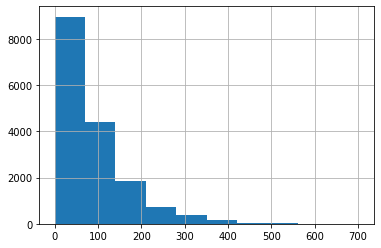

In [50]:
tx_user.Recency.hist()

In [51]:
# then this can be clustered and given different numbers
#frequecy 
tx_frequency = transactions_df.groupby('person').time.count().reset_index()
tx_frequency.columns = ['CustomerID', 'Frequency']

tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')
tx_user.head()

,CustomerID,Recency,Frequency
0,68be06ca386d4c31939f3a4f0e3dd783,18,9
1,0610b486422d4921ae7d2bf64640c50b,186,3
2,38fe809add3b4fcf9315a9694bb96ff5,18,6
3,78afa995795e4d85b5d9ceeca43f5fef,180,7
4,a03223e636434f42ac4c3df47e8bac43,102,3


In [53]:
# revenue sum up the amount we don't have a unit price --> sum the amount
tx_revenue = transactions_df.groupby('person').amount.sum().reset_index()
tx_revenue.columns = ['CustomerID', 'Revenue']
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')
tx_user.head()


,CustomerID,Recency,Frequency,Revenue
0,68be06ca386d4c31939f3a4f0e3dd783,18,9,20.40
1,0610b486422d4921ae7d2bf64640c50b,186,3,77.01
2,38fe809add3b4fcf9315a9694bb96ff5,18,6,14.30
3,78afa995795e4d85b5d9ceeca43f5fef,180,7,159.27
4,a03223e636434f42ac4c3df47e8bac43,102,3,4.65


In [54]:
# offers related 
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64